The idea is to use radial basis functions (RBF) to generate an intensity function for an inhomogeneous Poisson process. We can use a radial basis function, $\phi(t, \theta)$ with parameters $\theta$, the intensity by including weights

$$\lambda(t) = \sum_{m=1}^M w_m \phi(t, \theta_m)$$

For simplicity, I'll choose a gaussian RBF,

$$ \phi(t, t_0, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}}
                     \exp\left(-\frac{(t - t_0)^2}{2\sigma^2}\right) $$

The likelihood function for an inhomogeneous poisson process is 

$$ p(N | \lambda(t)) = \exp\left(-\int_0^T \lambda(t)\, dt\right) \prod_{i=1}^N \lambda(t_i) $$

where $t_i$ is the time of each of the N events. Since our intensity $\lambda(t)$ is modeled as a sum of nomalized RBFs, the integral simply becomes 

$$ \int_0^T \lambda(t)\, dt = \sum_{m=1}^M w_m $$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt

First I'll use the RBF model to generate some fake data.

In [19]:
radial_f = lambda x, loc, sig: sp.stats.norm.pdf(x, loc=loc, scale=sig)
def intensity(x, w, loc, sig, radial_func):
    return np.sum([wi*radial_func(x, li, si) 
                   for wi, li, si in zip(w, loc, sig)], axis=0)

In [27]:
# Calculate intensity
x = np.linspace(-1,1,num=100)
weights = [3, 2, 5, 3, 2]
locs = [-1, -0.5, 0, .5, 1]
bandwidths = [0.2]*5
lam = intensity(x, weights, locs, bandwidths, radial_f)

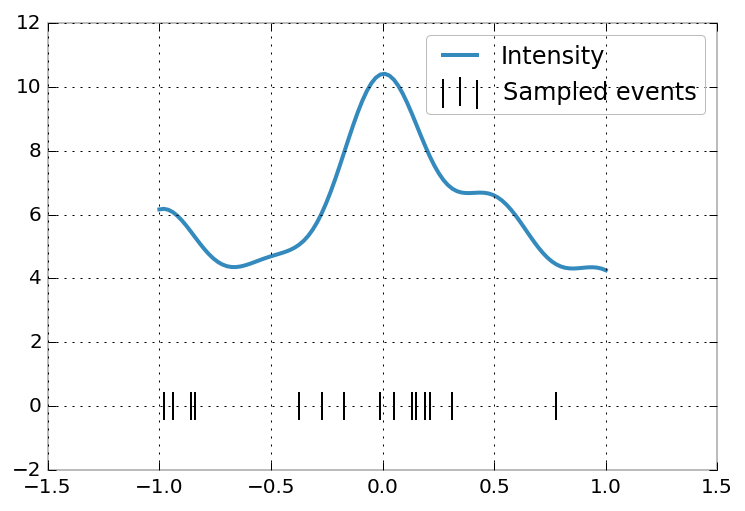

In [28]:
# Sample number of events
N = sp.stats.poisson(np.sum(weights)).rvs()
# Sample locations of N events
dist = sp.stats.rv_discrete(values=(range(len(x)), lam/sum(lam)))
events = dist.rvs(size=N)
events.sort()

plt.plot(x, lam, label="Intensity")
plt.scatter(x[events], np.zeros(N), color='k', marker='|', s=200, linewidths=1, label="Sampled events")
plt.legend()

Now I want to build a model to infer $\lambda(t)$ from data. To start out, I'm going to choose 5 RBFS, then have priors over the weights and the bandwidths.

I get stuck at this part though. I'm not sure how to generate the intensity function by summing up the RBFs. I can compile a function using `theano.scan` as seen [here](http://deeplearning.net/software/theano/library/scan.html), but the compiled function accepts numeric arrays, not symbolic objects like the defined priors (`weights` and `bandwidths`). So far, I haven't figured out how to loop over `weights` and `bandwidths`, passing them to `radial_gaussian`, then sum the resulting RBFs.

In [31]:
import pymc3 as pm
import theano
import theano.tensor as T

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [ ]:
def radial_gaussian(x, loc, sig):
        return T.exp(-(x - loc)**2/(2*sig**2))/(sig*np.sqrt(2*np.pi))

with pm.Model() as model:
    basis_D = 5
    weights = pm.Exponential('weights', 1, shape=(basis_D,))
    centers = theano.tensor.arange(-1,1.5,step=0.5, dtype="float64")
    bandwidths = pm.Exponential('bandwidths', 1, shape=(basis_D,))
    
    def intensity(t, weights, centers, bandwidths):
        # What to do?
        pass

    def logp(weights, centers, bandwidths, events):
        lam_t = intensity(events, weights, centers, bandwidths)
        return -T.sum(weights) + T.sum(T.log(lam_t))
    
    likelihood = pm.DensityDist('obs', logp, observed=(weights, centers, bandwidths, events))